In [ ]:
####----Convolutional Neural Network (CNN)-----########

In [3]:
#####---import Nessecary Libraries-----#####
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Activation
from PIL import Image
from random import shuffle

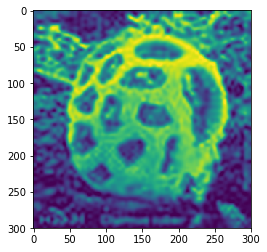

In [4]:
####---Load in Image Data for CNN, and then put them into format nessecary for CNN---##### ###--User Action Needed----#####
DIR = '/Users/Michael/ML-classification-of-grains/Resized_shrooms'            ##Note, file path is computer dependent
label_file = open('/Users/Michael/ML-classification-of-grains/poison_ids.txt')
lines = label_file.readlines()
labels = {}
for l in lines:
    ll = l.strip().split('\t')
    if ll[0] not in labels.keys():
        labels[ll[0]] = ll[1]


def label_img(name):
    return labels[name]

IMG_SIZE = 300
def load_training_data():
    train_data = []
    for img in os.listdir(DIR):
        name = img.split('.')[0]
        label = label_img(name)
        path = os.path.join(DIR, img)
        if "DS_Store" not in path:
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            train_data.append([np.array(img), label])

    shuffle(train_data)
    return train_data

train_data = load_training_data()


train_array=np.array(train_data)
plt.imshow(train_array[3,0])           #plot example image to ensure image_data still makes sense
train_images=train_array[:,0]          # rename train_array back to train_images

tempstore=np.zeros((905,300,300,1))    # Tensor Flow requires input images to be in certain four dimensional shape,
for ii in range(905):                  # so we initialized temptstore with right dimensions, and then put the data from
    temp=train_images[ii]              # train_images into this object in the proper way, and then finally renamed it..
    tempstore[ii,:,:,0]=temp           # train_images
train_images=tempstore


In [5]:
#####---Load Class Labels and put them in format nessecary for CNN-----#####        ####--User Action Needed-----#########

label_file = open('/Users/Michael/ML-classification-of-grains/poison_ids_noNA.txt') #Note, file path is computer dependent
lines = label_file.readlines()
labels = {}
for l in lines:
    ll = l.strip().split('\t')
    if ll[0] not in labels.keys():
        labels[ll[0]] = ll[1]

temp=list(labels.values())  ###---turn values of vict into a list temporarily

labels=np.zeros([len(temp)])   ###---use for loop to put values into an array
for ii in range(len(temp)):
    labels[ii]=temp[ii]

In [6]:
####---split image data and labels in train/test set
from sklearn.model_selection import train_test_split

Train_images, Test_images, train_labels, test_labels = train_test_split(train_images, labels, random_state=1, test_size=0.25)


In [7]:
# ####---Basic-Image-PreProcessing-For-CNN-----####
Train_images = Train_images.reshape((np.shape(Train_images)[0],300, 300, 1))   #### ensure image data is in the proper shape
Test_images = Test_images.reshape((np.shape(Test_images)[0], 300, 300, 1))

# Normalize pixel values to be between 0 and 1
Train_images=Train_images/255.0
Test_images=Test_images/255.0


###--Set Number of Classes----###
num_classes=2       ### we are attempting to classify mushroom images as poisonous or non poisonous, so there are two classes

Here we used tensorflow to build a CNN. The CNN consists of a convolutinal layer with 32 3X3 filters, followed by a Max Pooling layer with 2X2 grid, followed by an additional convolutional layer with 64 3X3 filters, another 2X2 Max Pooling layer, and a third convolutional layer with 64 3X3 filters. All non-pooling layers before the traditional network layers include a Rectiied Linear activation fuction, called 'relu' in tensorflow. After these layers, the output is flattened, and fed into a 64 node fully connected traditional neural network layer, which then feeds into a final fully connected layer with two nodes, one for each possible class output. This final layer uses softmax. 

In [8]:
#####-----Works on MNIST not CIFAR, is much faster to Train----###
model = models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), 
                 activation='relu',                                      
                 input_shape=(300,300,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))    
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(tf.layers.Flatten())
model.add(tf.layers.Dense(64, activation='relu'))
model.add(tf.layers.Dense(num_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
model.summary()   ####-shows a summary layout of the model just built

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 322624)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                20648000  
__________

In [10]:
#####---Here we compile and Train our Model-----########

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(Train_images, train_labels, epochs=1)   ###---Output Will Show Accuracy and loss of model during training Phase---###

678/678 [==============================] - 74s 110ms/sample - loss: 1.3398 - acc: 0.9086


In [11]:
####----predict_classes for one sample image-------#####
###----This will also set model.input to be this image, which will be of use in a few cells when the intermediate layers a visualized


img1=Test_images[5,:,:,0]          ###---grabed random images from Test_images
img2=np.expand_dims(img1,axis=0)   #####---Tensor flow requires 4d inputs, so we add an additional first and last dimension 
img2=np.expand_dims(img2,axis=3)
np.shape(img2)                    ####---shows the proper four dimensional shape of the input image

prediction=model.predict_classes(img2)
print(prediction)

[1]


In [12]:
###----Run Model on set of Test Images----######
scores = model.evaluate(Test_images, test_labels, verbose=1)

print('Test loss:', scores[0])

print('Test accuracy:', scores[1])

227/227 [==============================] - 10s 45ms/sample - loss: 1.2071 - acc: 0.9251
Test loss: 1.2070820441855208
Test accuracy: 0.92511016


In [ ]:
#######--------Visualization of Conv Layers--------#######

One way to gain an intuition about the workings of a CNN is to see the output images of the various filters in the various layers of the network. During training, the CNN develops filters that it convolves systematically over a 2D image to produce a new image of smaller dimensions.

-As a simplified example, one may imagine that a certain low level filter during training is trained to gives its largest response to an edge of certain orientation, the output of this low level filter to the input image would then show the edges of that orientation as especially bright.

-Generally speaking, later layers train fiters that respond to ever more abstract features of the image, while low level ones respond to simpler ones such as edges and corners.

-Here we show a given input image, a certain mushroom from our dataset, and then show the output images from each of the convolutional layers from our trained network.

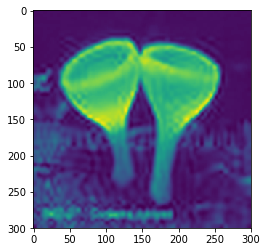

In [13]:
####-----plot sample image for demonstration----#######
plt.imshow(img1)              

In [14]:
####---Here we build the object activations that stores output of model in response to img1
layer_outputs=[]

for ii in range(8):
    layer_outputs.append(model.layers[ii].output)
activation_model2=models.Model(inputs=model.input,outputs=layer_outputs)


activations = activation_model2.predict(img2) 


###-method gleaned from https://keras.io/examples/cifar10_cnn/ (Reference 2)

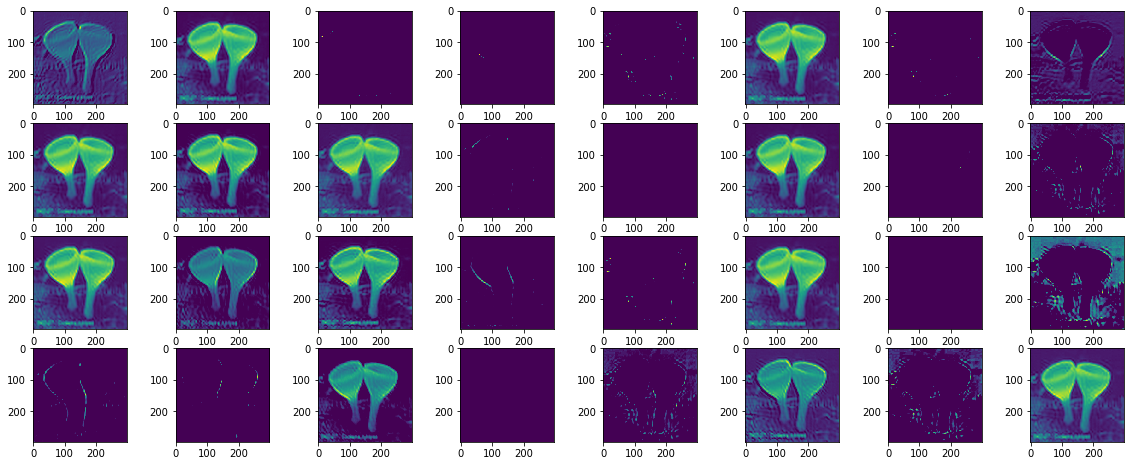

In [15]:
#####----plots output of 1st convolutional layer----######

#-This Layer has sixty four filters, so outputs 64 images

images11=[]
for ii in range(0,np.shape(activations[0])[3]):
    images11.append(activations[0][0,:,:,ii])

plt.figure(figsize=(20,10))
columns = 8
for i, image in enumerate(images11):
    plt.subplot(len(images11) / columns + 1, columns, i + 1)
    plt.imshow(images11[i])    

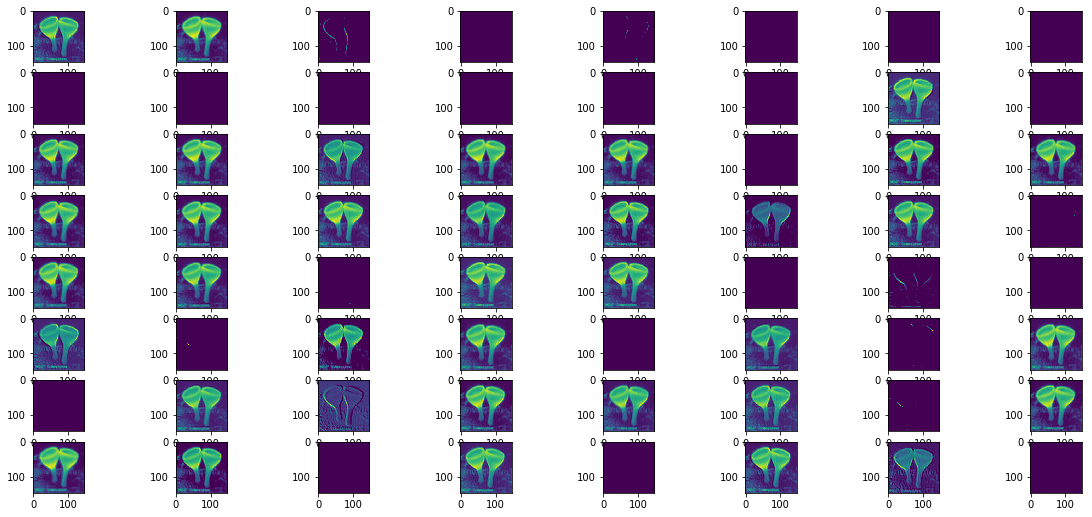

In [16]:
#####----plots output of 2nd Convolutional layer-----#######

images11=[]
for ii in range(0,np.shape(activations[2])[3]):
    images11.append(activations[2][0,:,:,ii])

plt.figure(figsize=(20,10))
columns = 8
for i, image in enumerate(images11):
    plt.subplot(len(images11) / columns + 1, columns, i + 1)
    plt.imshow(images11[i])   

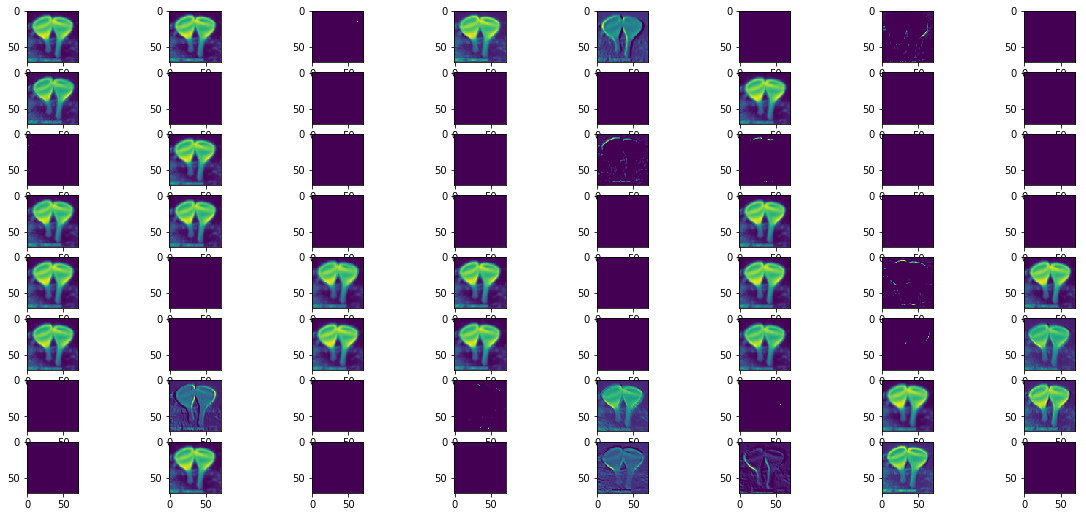

In [17]:
#####----plots output of 3rd Convolutional layer-----#######

images11=[]
for ii in range(0,np.shape(activations[4])[3]):
    images11.append(activations[4][0,:,:,ii])

plt.figure(figsize=(20,10))
columns = 8
for i, image in enumerate(images11):
    plt.subplot(len(images11) / columns + 1, columns, i + 1)
    plt.imshow(images11[i])   